# San Francisco Crime
## Considerations

### Imports

In [109]:
#Feature Engineering + Plotting
import pandas as pd
import matplotlib
import seaborn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math

#Machine Learning
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#Options
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
seaborn.set()

### Map
Before we dive into the data, we look at the map of San Francisco. The map data is from OpenStreetMap.

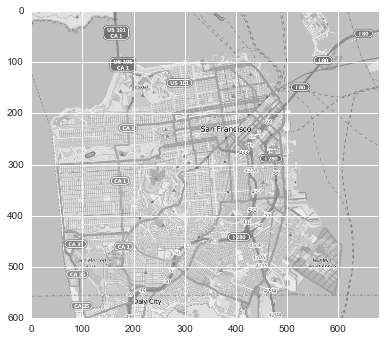

In [42]:
mapdata = np.loadtxt("../data/sf_map_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))

## Data
### Import Data

In [43]:
data_train = pd.read_csv('../data/train.csv', sep = ',')

### Rough Data Analysis
We see that there are 878049 observations and no missing values. For the numeric features we see that the Y (Latitude) feature has a min of 37.7 and 50% quantile of 37.77, but a max of 90. So it seems there are some outliers.

In [44]:
data_train.describe(percentiles=[]).transpose()

count        mean       std         min         50%    max
X  878049.0 -122.422616  0.030354 -122.513642 -122.416420 -120.5
Y  878049.0   37.771020  0.456893   37.707879   37.775421   90.0

The most important information from the following table for the categorical features is that there are 10 PdDistrists and 39 categories.

In [45]:
data_train.describe(percentiles=[], include=['O']).transpose()

count  unique                           top    freq
Dates       878049  389257           2011-01-01 00:01:00     185
Category    878049      39                 LARCENY/THEFT  174900
Descript    878049     879  GRAND THEFT FROM LOCKED AUTO   60022
DayOfWeek   878049       7                        Friday  133734
PdDistrict  878049      10                      SOUTHERN  157182
Resolution  878049      17                          NONE  526790
Address     878049   23228        800 Block of BRYANT ST   26533

### Target Variable
We need to predict in which category a crime falls using the other features. Therefore we use classification and not regression.

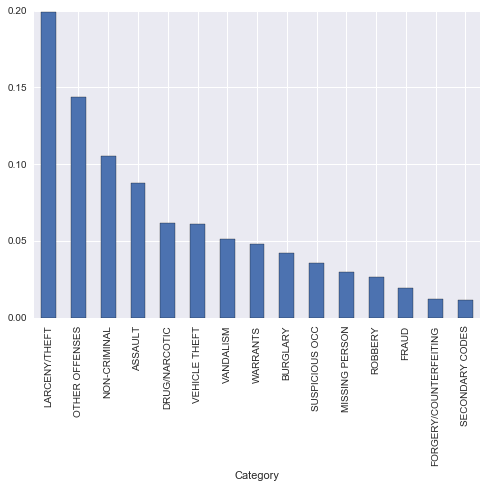

In [46]:
d = data_train.groupby('Category').size().sort_values(ascending=False)
dPercent = d / d.sum()
dPercent[:15].plot(kind='bar')

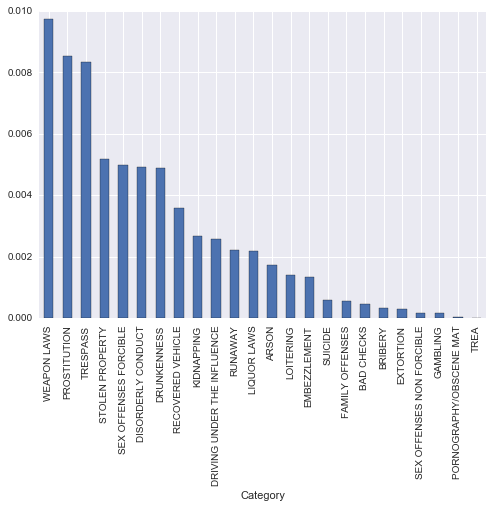

In [47]:
dPercent[15:].plot(kind="bar")

We see that the top 15 crimes (from 39) contain 93,33% of all crimes.

In [48]:
dPercent[:15].sum()

0.9331871000365582

In the following plot we see that different crimes happening at the same time and location is not rare and because of that we have to account for that while predicting

1     550477
2      97879
3      34002
4       4358
5       1392
6        467
7        165
8         80
9         39
10        18
11        11
12         6
13         5
16         1
14         1
dtype: int64

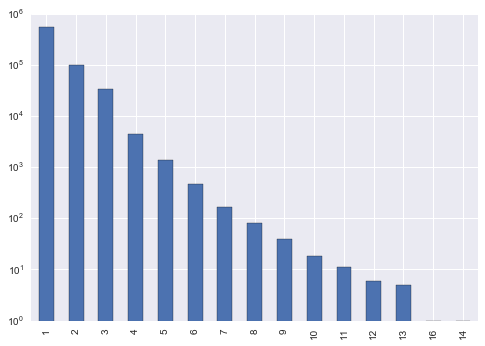

In [49]:
counts = data_train.groupby(['Dates', 'X', 'Y']).size()

counts.value_counts().plot('bar', logy=True)
counts.value_counts()

### Test Data
The training data and test data rotate every week. Besides the target variable "Category" also "Descript" and "Resolution" are missing from the the test set.

In [50]:
data_test = pd.read_csv('../data/test.csv', sep = ',')

We can only check if there are other PdDistrics in the test data, as locations will be different as this is real data. Also "Descript" and "Resolution" are not available in the test set.

In [51]:
len(np.setdiff1d(data_test['PdDistrict'].unique(), data_train['PdDistrict'].unique()))

0

### Data Anomalies
#### LongLat
First convert all X/Y Values to numeric to be able to compare them.

In [52]:
d_train_x = pd.to_numeric(data_train['X'])
d_train_y = pd.to_numeric(data_train['Y'])
d_test_x = pd.to_numeric(data_test['X'])
d_test_y = pd.to_numeric(data_test['Y'])

The values for the bounding box of the map are based on the agreed upon bounding box in the kaggle forums.

In [53]:
data_train["X"][(d_train_x < -122.52469) | (d_train_x > -122.33663)].unique()

array([-120.5])

In [54]:
data_train["Y"][(d_train_y < 37.69862) | (d_train_y > 37.82986)].unique()

array([ 90.])

In [55]:
data_test["X"][(d_test_x < -122.52469) | (d_test_x > -122.33663)].unique()

array([-120.5])

In [56]:
data_test["Y"][(d_test_y < 37.69862) | (d_test_y > 37.82986)].unique()

array([ 90.])

Outliers all (test and train data) have a Longtitude of -120.5 and a Latitude of 90. To get rid of these we preprocess the data.

### Data Preprocessing

In [57]:
def preprocess_coordinates(data):
    data = data[data['X'] != -120.5]
    data = data[data['Y'] != 90]
    return data

## Features

### Standard Features
As the target variable has 39 features, we didn't find any good visualisations whether the features correlate or not. Therefore we depend more upon the later feature importance

#### Dates
Using this feature, we derive all time based features. Also we could use this feature to derive DayOfWeek.

In [58]:
def feature_dates(data):
    data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d %H:%M:%S')
    return np.asarray(data['Dates']), ['Dates']

#### DayOfWeek
The Day of the week the crime was commited (From 'Monday' to 'Sunday')

In [59]:
def feature_day_of_week(data):
    return pd.get_dummies(data['DayOfWeek']), data['DayOfWeek'].unique().tolist()

#### PdDistrict
The name of the police department district

In [60]:
def feature_pd_district(data):
    return pd.get_dummies(data['PdDistrict']), data_train['PdDistrict'].unique().tolist()

#### Address
Approximate street address of the crime incident

In [61]:
def feature_address(data):
    return np.asarray(data['Address'])

#### X (Longitude) + Y (Latitude)
The commited crime is highly dependent on the location specified by Longtitude and Latitude

In [62]:
def feature_longitude(data):
    return (data.X - data.X.mean()) / data.X.std(), ['Longitude(X)']

In [63]:
def feature_latitude(data):
    return (data.Y - data.Y.mean()) / data.Y.std(), ['Latitude(Y)']

### Derived Features
#### Time-based
We use dummies for each of the datetime features (from year to minute).

In [64]:
def feature_year(data):
    df = data
    df['year'] = pd.to_datetime(data['Dates']).dt.year
    years = np.asarray(df['year'])
    return years, ['year']

In [65]:
def feature_month(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    months = np.asarray(df['month'])
    return months, ['month']

In [66]:
def feature_week(data):
    df = data
    df['week'] = pd.to_datetime(data['Dates']).dt.week
    weeks = np.asarray(df['week'])
    return weeks, ['week']

In [67]:
def feature_day(data):
    df = data
    df['day'] = pd.to_datetime(data['Dates']).dt.day
    days = np.asarray(df['day'])
    return days, ['day']

In [68]:
def feature_hour(data):
    df = data
    df['hour'] = pd.to_datetime(data['Dates']).dt.hour
    hour = np.asarray(df['hour'])
    return hour, ['hour']

In [69]:
def feature_minute(data):
    df = data
    df['minute'] = pd.to_datetime(data['Dates']).dt.minute
    minute = np.asarray(df['minute'])
    return minute, ['Minute']

Even though we have the hour feature, we try to abstract from it using day times

In [70]:
def feature_daytime(data):
    df = data
    df['hour'] = pd.to_datetime(data['Dates']).dt.hour
    daytimes = ['night', 'morning', 'noon', 'afternoon', 'evening']
    res = pd.cut(df['hour'], [-1,6,11,15,18,22,25], labels=['night', 'morning', 'noon', 'afternoon', 'evening', 'night2']).copy()
    res[res == 'night2'] = 'night'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), daytimes

We think that some crimes happen more often than other depending on the season

In [71]:
def feature_seasons(data):
    df = data
    df['month'] = pd.to_datetime(data['Dates']).dt.month
    seasons = ['winter', 'spring', 'summer', 'fall']
    res = pd.cut(df['month'], [0,2,3,8,11,12], labels=['winter', 'spring', 'summer', 'fall', 'winter2'])
    res[res == 'winter2'] = 'winter'
    res = res.cat.remove_unused_categories()
    res = pd.get_dummies(res)
    return np.asarray(res), seasons

We would like to know if some crimes can be predicted using a holiday feature. Luckily this time we know which holiday calendar to use (in contrast to DMC)

In [72]:
def feature_holiday(data):
    data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d')
    cal = calendar()
    date_range = pd.date_range(start='1/1/2003 ', end='5/13/2015') #known from description
    holidays = cal.holidays(start=date_range.min(), end=date_range.max())
    data['isHoliday'] = data['Dates'].dt.date.astype('datetime64').isin(holidays)
    return np.asarray(data['isHoliday']), ['isHoliday']

#There are 25653 holidays in the training set

The suicide rate on christmas is higher than on other times in the year

In [73]:
def feature_xmas(data):
    data['Dates'] = pd.to_datetime(data['Dates'])
    d = np.asarray(data['Dates'].dt.week > 48)
    return d, ['xmas']

#### Address-based
The crime happened on a street corner iff there are 2 addresses separated with an '/'

In [74]:
def feature_street_corner(data):
    d = np.asarray(data['Address'].apply(lambda x: 1 if '/' in x else 0))  
    return d, ['Street Corner']

In [75]:
def feature_add_ending(data):
    add_ending = ['ST', 'AV', 'WY', 'BL', 'DR', 'CT', 'TR', 'HY', 'RD', 'PZ', 'PL',
       'LN', 'AY', 'AL', 'CR', 'MS', 'ER', 'EX',
       'AR']    
    add = data['Address'].str[-2:]
    
    for i, ending in enumerate(add_ending):
        add[-add.isin(add_ending)] = 'NON'

    df = pd.get_dummies(add)
    
    return np.asarray(df), np.asarray(df.columns).tolist()

#### Location-based

Like others we tried to use a grid but without success.

Also we calculate which crime is most propable per region for the training and the test set

In [84]:
def feature_crimeProbPerReg(data):
    df = data
    bin_num = 10
    bin_labels = [i+1 for i in range(bin_num)]
    
    df['binX'], binsX = pd.cut(df.X, bin_num, labels=bin_labels, retbins=True)
    df['binY'], binsY = pd.qcut(df.Y, bin_num, labels=bin_labels, retbins=True)
        
    crimeProReg = df.groupby(['binX', 'binY', 'Category']).size().unstack('binX').unstack('binY')
    crimeProReg = crimeProReg/crimeProReg.sum()
    crimeProReg = crimeProReg.fillna(0)
    crimeProReg = crimeProReg.transpose()
    crimeProReg = crimeProReg.reset_index(['binX', 'binY'])

    pickle.dump(binsX, open("binsX.p", "wb"))
    pickle.dump(binsY, open("binsY.p", "wb"))
    pickle.dump(crimeProReg, open("crimeProbPerReg.p", "wb" ))  #save table with crime rates pro crime and region
    
    mergedR = df.merge(crimeProReg, on=['binX', 'binY'])#.fillna(0)
    res = mergedR.iloc[:, len(df.columns):len(mergedR.columns)]
    res = (res-res.mean())/res.std()
    return np.asanyarray(res), res.columns.tolist()

The following one is a distance based feature for the 15 most popular crime categories. First of all for every district the mean X and Y coordinates of the most popular crimes will calculated. After that distance of every crime to the mean coordinates will calculated as feature.

In [77]:
def feature_CrimeDistance(featureData):

    data = pd.read_csv('../data/train.csv')
    dataM = featureData.as_matrix()
    district = data['PdDistrict']
    districtU = district.unique()
    category = data['Category']
    popCategory = category.value_counts(normalize=False, sort=True, ascending=False, bins=None,)[:15]
    policeDepartment = featureData['PdDistrict'].as_matrix()

    #mean  x,y coordinates grouped by district and Category
    x_mean = data['X'].groupby([data['PdDistrict'],data['Category']]).mean()
    y_mean = data['Y'].groupby([data['PdDistrict'],data['Category']]).mean()

    # x,y coordinates for the generation of the features
    x = pd.to_numeric(featureData['X'].as_matrix())
    y = pd.to_numeric(featureData['Y'].as_matrix())

    # the matrizes are to store the mean coordinates
    X_meanTable = np.zeros((districtU.shape[0], (popCategory.shape[0])))
    Y_meanTable = np.zeros((districtU.shape[0], (popCategory.shape[0])))

    # the mean coordinates are stored within the following for loop
    for i in range(0, districtU.shape[0]):

        for j in range(0, popCategory.shape[0]):

            X_meanTable[i][j] = x_mean[districtU[i]][popCategory.index[j]]
            Y_meanTable[i][j] = y_mean[districtU[i]][popCategory.index[j]]

    # declaration of the empty dataframe for storing the new features
    df = np.zeros((dataM.shape[0],popCategory.size))
    names = []

    # the first loop iterates through the popular categories
    for t in range(0, popCategory.size):

        names.append('distance_' + str(popCategory.index[t]))

        # the second loop iterates through the input dataframe which is for generation
        for i in range(0, dataM.shape[0]):

            for j in range(0, districtU.size):

                # the last loop is to check which district is to use
                if (policeDepartment[i] == districtU[j]):
                    # calculation of the inverse of the euclidian distance
                    df[i][t] = 1/(math.sqrt((x[i] - X_meanTable[j][t]) ** 2 + (y[i] - Y_meanTable[j][t]) ** 2))

    # normalization 
    dFrame = pd.DataFrame(np.asarray(df))
    dFrame = (dFrame - dFrame.mean())/dFrame.std()

    return np.asarray(dFrame), names

### Left out Features
The following features were left out early on.

#### Descript
This feature is not available in the test set and is only a description of the crime.

#### Resolution
This one is also not available in the test set. The only thing we could imagine to use the percentage of crimes solved of a all crime categories as we think that crimes that get resolved more often don't get commited as often.

### Generate Feature Set

In [104]:
def getY(data):
    numCat = len(data['Category'].unique()) 
    d = data['Category']
    d = d.astype('category')
    d = d.cat.rename_categories(np.arange(numCat))
    return np.asarray(d)

def getX(data, test_set=False):    
    feature_methodes = [  feature_pd_district, feature_daytime,
                          feature_day_of_week, feature_seasons, feature_street_corner,
                          feature_year, feature_latitude, feature_longitude,
                          feature_month, feature_week, feature_hour, feature_minute,
                          feature_holiday, feature_xmas, feature_add_ending,
                          feature_CrimeDistance]

    if not test_set:
        feature_methodes.append(feature_crimeProbPerReg)
    
    feats = []
    names = []

    for func in feature_methodes:
        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        print(f.shape)    
        feats.append(f)
        names.extend(n)
    
    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names

In [105]:
print("get train and test features")

train_data, test_data = train_test_split(data_train, test_size=0.3)

train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)
test_y = getY(test_data)

get train and test features
<function feature_pd_district at 0x7f5c19c3fae8>
(614587, 10)
<function feature_daytime at 0x7f5c1986cb70>
(614587, 5)
<function feature_day_of_week at 0x7f5c19bed840>
(614587, 7)
<function feature_seasons at 0x7f5c1986c510>
(614587, 4)
<function feature_street_corner at 0x7f5c197dc730>
(614587, 1)
<function feature_year at 0x7f5c05f85620>
(614587, 1)
<function feature_latitude at 0x7f5c19bb6158>
(614587, 1)
<function feature_longitude at 0x7f5c197dcae8>
(614587, 1)
<function feature_month at 0x7f5c05f76840>
(614587, 1)
<function feature_week at 0x7f5c05f76730>
(614587, 1)
<function feature_hour at 0x7f5c1986c400>
(614587, 1)
<function feature_minute at 0x7f5c19bb6598>
(614587, 1)
<function feature_holiday at 0x7f5c19c48378>
(614587, 1)
<function feature_xmas at 0x7f5c05f85048>
(614587, 1)
<function feature_add_ending at 0x7f5c1989f598>
(614587, 20)
<function feature_CrimeDistance at 0x7f5c19b1fb70>
(614587, 15)
<function feature_crimeProbPerReg at 0x7f5c12c

### Feature Selection

Random Forests can be used to get the feature importance

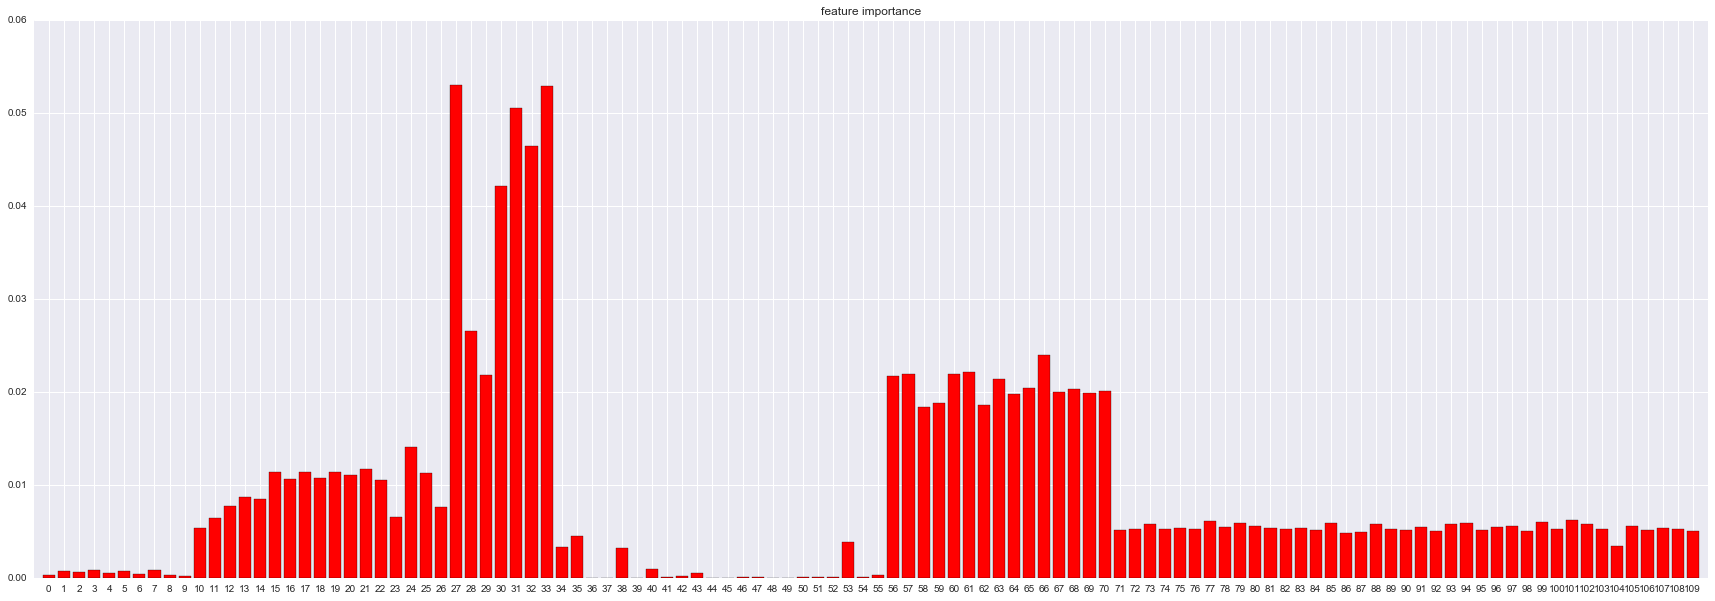

0 NORTHERN 0.000315089155215
1 PARK 0.000681809245456
2 INGLESIDE 0.000659293771764
3 BAYVIEW 0.000891603604482
4 RICHMOND 0.000544236755983
5 CENTRAL 0.000768437029679
6 TARAVAL 0.000430524956626
7 TENDERLOIN 0.000881950924439
8 MISSION 0.000329441669047
9 SOUTHERN 0.000185661072288
10 night 0.00537306414716
11 morning 0.00648019232264
12 noon 0.00774548057388
13 afternoon 0.00872698979976
14 evening 0.00850840885912
15 Sunday 0.011395734054
16 Monday 0.0105930887654
17 Friday 0.0113629092077
18 Wednesday 0.0107514277828
19 Saturday 0.0113860416899
20 Thursday 0.0110680613153
21 Tuesday 0.0116526087691
22 winter 0.0105262678348
23 spring 0.00651435574386
24 summer 0.0140447974392
25 fall 0.0112577678529
26 Street Corner 0.00758146584683
27 year 0.0529908034692
28 Latitude(Y) 0.0265050266292
29 Longitude(X) 0.0218317923059
30 month 0.0421705914672
31 week 0.0504932134304
32 hour 0.0464194455552
33 Minute 0.0529136596499
34 isHoliday 0.00326317245101
35 xmas 0.00446651294752
36 AL 3.867

In [87]:
model =RandomForestClassifier(n_estimators=1)

train = model.fit(train_x, train_y)
pred = model.predict(test_x)

# feature importance
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importance)[::-1]

#bar chart plot for feature importance
#because of the huge number of the features, legend of the bars are shown in the terminal
plt.figure(figsize=(30, 10))
plt.title("feature importance")
plt.bar(range(importance.shape[0]), importance, color="r", align="center")
plt.xlim([-1, importance.shape[0]])
plt.xticks(range(importance.shape[0]))
plt.show()

counter = 0
for i in range(indices.shape[0]):
        print(str(i) + " " + str(names[i]) + " " + str(importance[i]))

### Get Final Feature Set
Based on the feature importance we only use features with some importance

In [102]:
def getY(data):
    numCat = len(data['Category'].unique()) 
    d = data['Category']
    d = d.astype('category')
    d = d.cat.rename_categories(np.arange(numCat))
    return np.asarray(d)

def getX(data, test_set=False):    
    feature_methodes = [  feature_daytime, feature_day_of_week,\
                        feature_seasons, feature_street_corner,\
                          feature_year, feature_latitude, feature_longitude,\
                          feature_month, feature_week, feature_hour, feature_minute,\
                          feature_holiday, feature_xmas, feature_CrimeDistance]
    
    if not test_set:
        #doesn't work with test set
        feature_methodes.append(feature_crimeProbPerReg)
    
    feats = []
    names = []

    for func in feature_methodes:
        print(func)
        f, n = func(data)
        if f.ndim == 1:
            f = f.reshape([f.shape[0],1])
        print(f.shape)    
        feats.append(f)
        names.extend(n)
    
    data_set = np.concatenate([f for f in feats], axis=1).astype(float)
    return data_set, names

In [89]:
print("get train and test features")

train_data, test_data = train_test_split(data_train, test_size=0.3)

train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)
test_y = getY(test_data)

get train and test features
<function feature_daytime at 0x7f5c1986cb70>
(614634, 5)
<function feature_day_of_week at 0x7f5c19bed840>
(614634, 7)
<function feature_seasons at 0x7f5c1986c510>
(614634, 4)
<function feature_street_corner at 0x7f5c197dc730>
(614634, 1)
<function feature_year at 0x7f5c05f85620>
(614634, 1)
<function feature_latitude at 0x7f5c19bb6158>
(614634, 1)
<function feature_longitude at 0x7f5c197dcae8>
(614634, 1)
<function feature_month at 0x7f5c05f76840>
(614634, 1)
<function feature_week at 0x7f5c05f76730>
(614634, 1)
<function feature_hour at 0x7f5c1986c400>
(614634, 1)
<function feature_minute at 0x7f5c19bb6598>
(614634, 1)
<function feature_holiday at 0x7f5c19c48378>
(614634, 1)
<function feature_xmas at 0x7f5c05f85048>
(614634, 1)
<function feature_CrimeDistance at 0x7f5c19b1fb70>
(614634, 15)
<function feature_crimeProbPerReg at 0x7f5c12c449d8>
(614634, 39)
<function feature_daytime at 0x7f5c1986cb70>
(263415, 5)
<function feature_day_of_week at 0x7f5c19bed84

For training our model we need to split our test data

In [90]:
train_data, test_data = train_test_split(data_train, test_size=0.3)

In [91]:
train_x, names = getX(train_data)
train_y = getY(train_data)

test_x, names = getX(test_data, test_set=True)

<function feature_daytime at 0x7f5c1986cb70>
(614634, 5)
<function feature_day_of_week at 0x7f5c19bed840>
(614634, 7)
<function feature_seasons at 0x7f5c1986c510>
(614634, 4)
<function feature_street_corner at 0x7f5c197dc730>
(614634, 1)
<function feature_year at 0x7f5c05f85620>
(614634, 1)
<function feature_latitude at 0x7f5c19bb6158>
(614634, 1)
<function feature_longitude at 0x7f5c197dcae8>
(614634, 1)
<function feature_month at 0x7f5c05f76840>
(614634, 1)
<function feature_week at 0x7f5c05f76730>
(614634, 1)
<function feature_hour at 0x7f5c1986c400>
(614634, 1)
<function feature_minute at 0x7f5c19bb6598>
(614634, 1)
<function feature_holiday at 0x7f5c19c48378>
(614634, 1)
<function feature_xmas at 0x7f5c05f85048>
(614634, 1)
<function feature_CrimeDistance at 0x7f5c19b1fb70>
(614634, 15)
<function feature_crimeProbPerReg at 0x7f5c12c449d8>
(614634, 39)
<function feature_daytime at 0x7f5c1986cb70>
(263415, 5)
<function feature_day_of_week at 0x7f5c19bed840>
(263415, 7)
<function fea

## Classification
For each tried Classifier we output the accuracy as we found the logloss using a split instead of the real test data to be meaningless. We especially saw this by using XGBoost. The logloss with split was 1.9 but on the test data it was 15.

### Naive Bayes
This model is also a statistical approach. It trains a Naive bayes network and classifies the data with the aposteriori likelihood. Its a very fast benchmark classificator which provides in this case the poorest results

In [92]:
model = GaussianNB()

print("Train NB")
train = model.fit(train_x, train_y)

print("Test NB")
pred = model.predict(test_x)

print("Evaluate NB")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))

Train NB
Test NB
Evaluate NB
Confusion Matrix
[[  0   0  12 ...,   0   0   0]
 [ 12  40 687 ...,  30  16  17]
 [  0   0   5 ...,   0   0   0]
 ..., 
 [ 10  41 438 ...,  22  15  10]
 [ 11  24 362 ...,  21   8   9]
 [  1   4  84 ...,   1   2   2]]
Accuracy
0.0107662813431


### Random Forest
Random Forest is classificator which generates many decision trees with random samples. For every tree it try to maximize the information gain. It classifies according to a majority decision

In [94]:
model = RandomForestClassifier(n_estimators=10)

print("Train RF")
train = model.fit(train_x, train_y)

print("Test RF")
pred = model.predict(test_x)

print("Evaluate RF")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))

Train RF
Test RF
Evaluate RF
Confusion Matrix
[[   0   58    1 ...,   27    6    1]
 [  19 3176    2 ...,  982  387   30]
 [   0   25    0 ...,    4    1    0]
 ..., 
 [  10 2264    3 ...,  685  285   18]
 [  14 1701    0 ...,  529  221   13]
 [   3  345    0 ...,   97   47    2]]
Accuracy
0.124002049997


### Stochastic Gradient Descent with SVM
This Classifier trains for every level of the Output a separate svm (one against all) with the learning methods stochastic gradient descent. This learning methods updating the weight vector in direction with the steepest error reduction.

In [95]:
model = SGDClassifier()

print("Train SVM")
train = model.fit(train_x, train_y)

print("Test SVM")
pred = model.predict(test_x)

print("Evaluate SVM")
print("Confusion Matrix")
print(confusion_matrix(test_y, pred))
print("Accuracy")
print(accuracy_score(test_y, pred))

Train SVM
Test SVM
Evaluate SVM
Confusion Matrix
[[  0   3   0 ...,   0   1   0]
 [  0 141   0 ...,   0   6  25]
 [  0   0   0 ...,   0   0   0]
 ..., 
 [  0 106   0 ...,   0   5  22]
 [  0  69   0 ...,   0   4  18]
 [  0  16   0 ...,   0   1   0]]
Accuracy
0.198029724959


### AdaBoost Classifier

This is a meta-estimator that first fits the original dataset and then fits additional copies of the classifier on the same dataset. To do this but weights of misclassified instances are adjusted so it focuses more on edge cases

In [97]:
print("Train AdaBoost")
model = AdaBoostClassifier(n_estimators = 25)
%time model.fit(train_x, train_y)

print("Test AdabBoost")
pred = model.predict_proba(test_x)

Train AdaBoost
CPU times: user 2min 24s, sys: 7.58 s, total: 2min 31s
Wall time: 2min 32s
Test AdabBoost


### XGBoost
XGBoost is short for Extreme Gradient Boosting and is an implementation of the gradient boosting framework.

In [99]:
xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x, label=test_y)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 39
param['eval_metric'] = 'mlogloss'
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 10

print("Train XGBoost")
bst = xgb.train(param, xg_train, num_round, watchlist );

print("Test XGBoost")
pred = bst.predict( xg_test );

Train XGBoost


[0]	train-mlogloss:3.385007	test-mlogloss:3.533259
[1]	train-mlogloss:3.219112	test-mlogloss:3.448034
[2]	train-mlogloss:3.093881	test-mlogloss:3.382434
[3]	train-mlogloss:2.990891	test-mlogloss:3.330128
[4]	train-mlogloss:2.904534	test-mlogloss:3.287073
[5]	train-mlogloss:2.829955	test-mlogloss:3.250633
[6]	train-mlogloss:2.764674	test-mlogloss:3.219807
[7]	train-mlogloss:2.706642	test-mlogloss:3.192828
[8]	train-mlogloss:2.654862	test-mlogloss:3.169922
[9]	train-mlogloss:2.608263	test-mlogloss:3.149657


Test XGBoost


## Result

For our submission we use XGBoost as we got the best results with it.

In [106]:
data_train = pd.read_csv('../data/train.csv', sep = ',')
data_test = pd.read_csv('../data/test.csv', sep = ',')

data_train = preprocess_coordinates(data_train)


train_x, names = getX(data_train)
train_y = getY(data_train)
test_x, names = getX(data_test, test_set=True)

xg_train = xgb.DMatrix( train_x, label=train_y)
xg_test = xgb.DMatrix(test_x)

bst = xgb.train(param, xg_train, num_round, watchlist )
pred = bst.predict( xg_test )

<function feature_pd_district at 0x7f5c19c3fae8>
(877982, 10)
<function feature_daytime at 0x7f5c1986cb70>
(877982, 5)
<function feature_day_of_week at 0x7f5c19bed840>
(877982, 7)
<function feature_seasons at 0x7f5c1986c510>
(877982, 4)
<function feature_street_corner at 0x7f5c197dc730>
(877982, 1)
<function feature_year at 0x7f5c05f85620>
(877982, 1)
<function feature_latitude at 0x7f5c19bb6158>
(877982, 1)
<function feature_longitude at 0x7f5c197dcae8>
(877982, 1)
<function feature_month at 0x7f5c05f76840>
(877982, 1)
<function feature_week at 0x7f5c05f76730>
(877982, 1)
<function feature_hour at 0x7f5c1986c400>
(877982, 1)
<function feature_minute at 0x7f5c19bb6598>
(877982, 1)
<function feature_holiday at 0x7f5c19c48378>
(877982, 1)
<function feature_xmas at 0x7f5c05f85048>
(877982, 1)
<function feature_add_ending at 0x7f5c1989f598>
(877982, 20)
<function feature_CrimeDistance at 0x7f5c19b1fb70>
(877982, 15)
<function feature_crimeProbPerReg at 0x7f5c12c449d8>
(877982, 39)
<functio

[0]	train-mlogloss:3.539716	test-mlogloss:3.546294
[1]	train-mlogloss:3.448855	test-mlogloss:3.461509
[2]	train-mlogloss:3.386573	test-mlogloss:3.402787
[3]	train-mlogloss:3.347249	test-mlogloss:3.364933
[4]	train-mlogloss:3.314435	test-mlogloss:3.335706
[5]	train-mlogloss:3.284819	test-mlogloss:3.309959
[6]	train-mlogloss:3.262975	test-mlogloss:3.288105
[7]	train-mlogloss:3.243039	test-mlogloss:3.268077
[8]	train-mlogloss:3.226800	test-mlogloss:3.254879
[9]	train-mlogloss:3.201965	test-mlogloss:3.233664


In [107]:
output = pd.DataFrame(pred, index=data_test.index, columns=data_train['Category'].unique())
output.to_csv("results.csv", index_label="Id")

Real score (using kaggle): 3.84409  
On monday we got a better score with just one step: 3.66774 (Rank 1734)